<a href="https://colab.research.google.com/github/fathanzys/Data/blob/Machine-Learning/Model-Prediktif-Asuransi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Model Prediktif Biaya Asuransi Berdasarkan Gaya Hidup Pasien**

**Tujuan Utama**
Memprediksi nilai charges (biaya asuransi kesehatan) berdasarkan karakteristik pribadi seseorang (usia, jenis kelamin, status merokok, BMI, dll) dengan menggunakan berbagai model machine learning regresi.

#**Library**

In [47]:
import pandas as pd
import numpy as py
import matplotlib.pyplot as plt
import seaborn as sns

#**1. Data Collection**

In [48]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Latihan - 1/medical_insurance.csv')

In [50]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#**2. EDA**

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [52]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [54]:
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


#**3. Features Engineering**

In [58]:
from sklearn.preprocessing import LabelEncoder

region_encoded = pd.get_dummies(df['region'], dtype=int, drop_first=False)

In [60]:
df['sex'] = pd.get_dummies(df['sex'], dtype=int, drop_first=True)
df['smoker'] = pd.get_dummies(df['smoker'], dtype=int, drop_first=True)

In [61]:
df = pd.concat([df.drop(columns=['region']), region_encoded], axis=1)

In [62]:
categorial_features = ['sex', 'children', 'smoker', 'northeast', 'southeast', 'northwest', 'southwest']
for feature in categorial_features:
  mean_target = df.groupby(feature)['charges'].mean()
  df[f'{feature}_mean_charges'] = df[feature].map(mean_target)

#**4. Data Modelling**

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [65]:
x = df.drop(columns=['charges']).values
y = df['charges'].values.reshape(-1,1)

In [69]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
print('data.shapes', x_train, x_test, y_train, y_test)

data.shapes [[0.45652174 1.         0.37570621 ... 0.         1.         1.        ]
 [0.76086957 1.         0.40893193 ... 0.         0.         1.        ]
 [0.47826087 0.         0.54425612 ... 1.         1.         1.        ]
 ...
 [0.69565217 1.         0.54452515 ... 0.         1.         0.        ]
 [0.65217391 1.         0.39870864 ... 0.         1.         1.        ]
 [0.56521739 1.         0.37059457 ... 0.         1.         1.        ]] [[0.39130435 0.         0.31692225 ... 0.         1.         1.        ]
 [0.93478261 1.         0.41996234 ... 1.         1.         1.        ]
 [0.80434783 0.         0.45238095 ... 0.         0.         1.        ]
 ...
 [0.         1.         0.42426688 ... 0.         1.         1.        ]
 [0.08695652 0.         0.64151197 ... 0.         1.         1.        ]
 [0.47826087 0.         0.37261232 ... 1.         1.         1.        ]] [[0.34063308]
 [0.14908733]
 [0.07658964]
 ...
 [0.11709678]
 [0.14396601]
 [0.49461299]] [[6.938919

#**5. Model Training**

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from tqdm import tqdm as tqdm

In [98]:
scores = {}
models = [LinearRegression, GradientBoostingRegressor, RandomForestRegressor, SVR]

for model_class in models:
    model = model_class()
    model.fit(x_train, y_train)
    prediction = model.predict(x_test).reshape(y_test.shape)
    r2 = r2_score(y_test, prediction)
    scores[model_class.__name__] = r2

print(scores)

{'LinearRegression': 0.7488501497880855, 'GradientBoostingRegressor': 0.8859967941208102, 'RandomForestRegressor': 0.9476564909565937, 'SVR': 0.7104465681799831}


#**6. Hyperparameter Tuning**

In [82]:
from sklearn.model_selection import GridSearchCV
import joblib

In [83]:
param_grid_rfr = {
    'n_estimators': [20, 40, 80, 100, 150],
    'max_features': [1.0, 'log2'],
    'max_depth': [None, 20, 30, 40, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [84]:
rfr =  RandomForestRegressor()
grid = GridSearchCV(estimator=rfr, param_grid=param_grid_rfr, cv=5, n_jobs=-1, verbose=0)
grid.fit(x_train, y_train.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 20, 30, 40, 50],
                         'max_features': [1.0, 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [20, 40, 80, 100, 150]})

In [85]:
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)
print("best parameter is: ", grid.best_params_)
print("test r2: ", r2_score(y_test, y_pred))

best parameter is:  {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
test r2:  0.958330010312503


In [86]:
joblib.dump(best_model,'./trained_model-0.1.0.pkl')

['./trained_model-0.1.0.pkl']

#**7. Evaluation**

In [87]:
model = joblib.load('./trained_model-0.1.0.pkl')

In [88]:
y_pred = model.predict(x_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred_inv = y_pred_inv.flatten()

In [92]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
print("R2 Score:", r2_score(y_test_inv, y_pred_inv))

R2 Score: 0.958330010312503


In [94]:
importances = model.feature_importances_
features = df.drop(columns='charges').columns

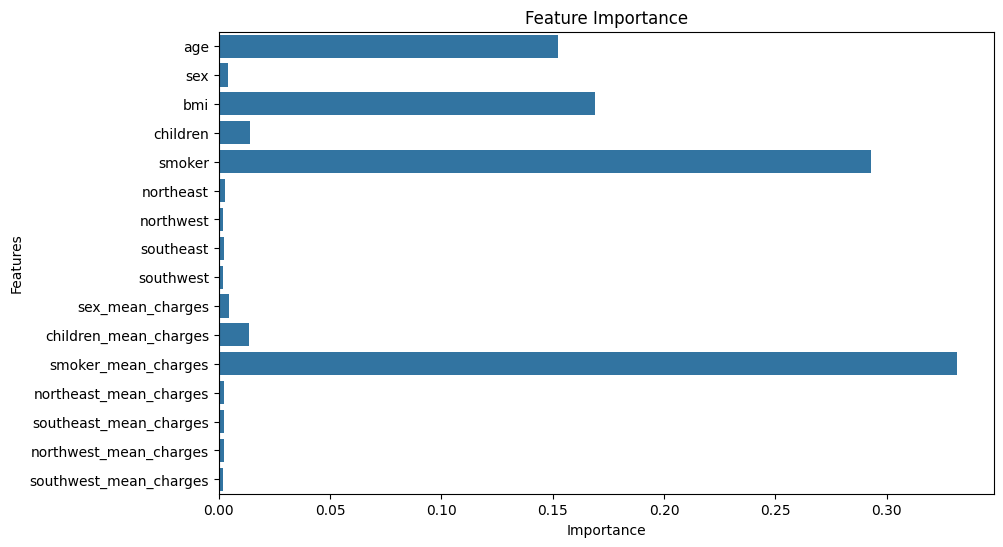

In [96]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

#**8. Visualization**

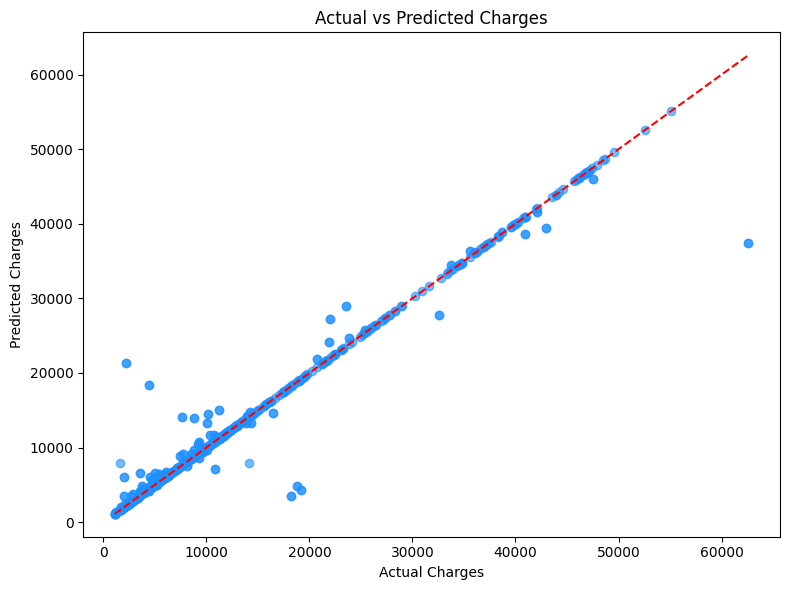

In [97]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6, color='dodgerblue')
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.tight_layout()
plt.show()